In [1]:
using HePPCAT, LinearAlgebra, Plots, Random, Statistics, StatsPlots, Printf
using Plots.PlotMeasures
include("petrels.jl")
include("grouse.jl")
include("shasta1.jl")
include("shasta2.jl")
include("plotting.jl")

plottimetraces (generic function with 3 methods)

### Dynamic subspace

In [19]:
d, v, λ = 100, [1e-4,1e-2], [4,2,1]
# d, v, λ = 100, [1e-5,1e-2], [4,2,1]
# d, v, λ = 100, [1e-2,5*1e-1], [4,2,1]
k, L = length(λ), length(v)
θ = 0.998
# θ = 0.999
δ = 0.1

# w = 0.01
# wf = 0.01
# wv = 0.1

w = 0.01
# w = 0.001
cf = 0.01
cv = 0.1

# w1 = w
# w2 = w
# grouse_step = 0.02
grouse_step = 0.01
khat = 3

# num_vectors = 10000 #total number of vectors
num_vectors = 20000
p = [1/5 4/5] #probabilites to draw the two groups from

changeFIdx = 1:10000:num_vectors

M0 = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),rand(L))

## Init models
M_petrels = deepcopy(M0)
M_shasta = deepcopy(M0)
M_grouse = deepcopy(M0)

## Memory terms

petrelsRₜ⁺ = [δ*Matrix(I(k)) for i=1:d]

R = [δ*Matrix(I(k)) for i=1:d]
s = [zeros(k) for i=1:d]
ρ = zeros(L)
θshasta = zeros(L)

## Init stat logs
err_log_onlineHeppcat = []
err_log_petrels = []
err_log_shasta = []
err_log_grouse = []

U = qr(rand(d,k)).Q[:,1:k]
F = U*sqrt(Diagonal(λ))

function Fmeasure(M,F)
#     Fhat = M.U * Diagonal(M.λ).^(0.5) * M.Vt
#     return norm(Fhat*Fhat' - F*F') / norm(F*F')
    Uf = svd(F).U[:,1:k]
    Uhat = M.U
    
    return norm(Uhat*Uhat' - Uf*Uf') / norm(Uf*Uf')
end

missing = 0.5
err_fxn(M) = Fmeasure(M,F)
for t = 1:num_vectors
    
    ## Draw data vector
    if(t in changeFIdx)
        U = qr(rand(d,k)).Q[:,1:k]
        F = U*sqrt(Diagonal(λ))
        err_fxn(M) = Fmeasure(M,F)
    end
    l = rand() > (p[2]) ? 1 : 2
    Ωₜ = rand(d) .> missing
    yₜ  = Ωₜ .* (F*randn(k) + sqrt(v[l])*randn(d))

    ## Run the models
    streamPETRELS!(M_petrels,yₜ,Ωₜ,petrelsRₜ⁺,θ)
#     streamSHASTA!(M,yₜ,Ωₜ,l,w,cf,cv,R,s,ρ,θ)
    streamSHASTA2!(M_shasta,yₜ,Ωₜ,l,w,cf,cv,R,s,ρ,θshasta)
    streamGROUSE!(M_grouse, yₜ, Ωₜ, grouse_step)
    
    ## Collect stats
    push!(err_log_petrels, err_fxn(M_petrels))
    push!(err_log_shasta, err_fxn(M_shasta))
    push!(err_log_grouse, err_fxn(M_grouse))
    
end

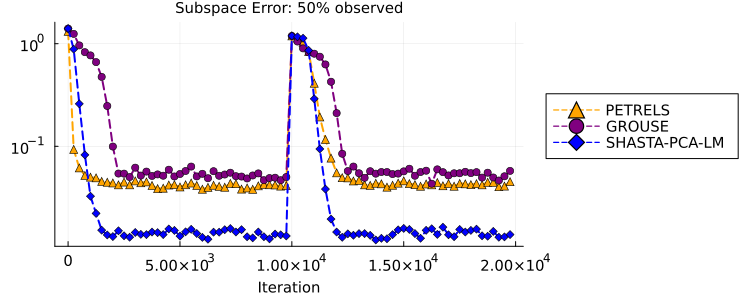

In [20]:
errs = [[err_log_petrels], [err_log_grouse], [err_log_shasta]]

labels = ["PETRELS","GROUSE","SHASTA-PCA-LM"]
colors = Dict("PETRELS"=>:orange,"GROUSE"=>:purple,"SHASTA-PCA-LM"=>:blue)
markers = Dict("PETRELS"=>:utriangle,"GROUSE"=>:circle,"SHASTA-PCA-LM"=>:diamond)

missing_rate = Int(round((1-missing)*100))
interval = 250
alpha = 0.05
fontsize = 10
figsize = (750,300)


p1 = plottraces(errs,labels,colors,markers,interval,alpha,figsize,fontsize,
    "Subspace Error: $missing_rate% observed","Iteration",:outerright,:log)
plot!(p1,size=figsize,bottom_margin=5mm)
file = "/Users/kgilman/Desktop/streaming-hppca/Streaming-Heteroscedastic-PPCA/shasta_results/online_algs_dynamic-d_$d-n_$num_vectors-observedPercent_$missing_rate-v1_" * @sprintf("%.2E", v[1]) * "-v2_"* @sprintf("%.2E", v[2]) * ".pdf"
# savefig(p1,file)
plot!(p1)

In [21]:
M_shasta.v

2-element Vector{Float64}:
 0.00010304083758319894
 0.01003534123697587

In [22]:
M_shasta.λ

3-element Vector{Float64}:
 1.2766946135738242
 0.7766123138812744
 0.4221839230945428

### Dynamic variances

##### Increasing v1

In [49]:
d, v, λ = 100, [1e-4,1e-2], [4,2,1]
k, L = length(λ), length(v)
θ = 0.998
δ = 0.1

# w = 0.01
# wf = 0.01
# wv = 0.1

w = 0.01
cf = 0.01
cv = 0.1

# w1 = w
# w2 = w
grouse_step = 0.01
khat = 3

# num_vectors = 10000 #total number of vectors
num_vectors = 20000
p = [1/5 4/5] #probabilites to draw the two groups from
change = 5000
changeFIdx = 1:change:num_vectors

M0 = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),rand(L))

## Init models
M_petrels = deepcopy(M0)
M_shasta = deepcopy(M0)
M_grouse = deepcopy(M0)

## Memory terms

petrelsRₜ⁺ = [δ*Matrix(I(k)) for i=1:d]

R = [δ*Matrix(I(k)) for i=1:d]
s = [zeros(k) for i=1:d]
ρ = zeros(L)
θshasta = zeros(L)

## Init stat logs
err_log_onlineHeppcat = []
err_log_petrels = []
err_log_shasta = []
err_log_grouse = []


U = qr(rand(d,k)).Q[:,1:k]
F = U*sqrt(Diagonal(λ))

function Fmeasure(M,F)
#     Fhat = M.U * Diagonal(M.λ).^(0.5) * M.Vt
#     return norm(Fhat*Fhat' - F*F') / norm(F*F')
    Uf = svd(F).U[:,1:k]
    Uhat = M.U
    
    return norm(Uhat*Uhat' - Uf*Uf') / norm(Uf*Uf')
end

missing = 0.5
# err_fxn(M) = Fmeasure(M,F)
# err_fxn(M) = [abs(M.v[l] - v[l]) for l=1:L]
err_fxn(M) = deepcopy(M.v)
for t = 1:num_vectors
    
    ## Draw data vector
    if(t in changeFIdx)
        v[1] = 2*v[1]
#         err_fxn(M) = [abs(M.v[l] - v[l])/v[l] for l=1:L]
    end
    l = rand() > (p[2]) ? 1 : 2
    Ωₜ = rand(d) .> missing
    yₜ  = Ωₜ .* (F*randn(k) + sqrt(v[l])*randn(d))

    ## Run the models
#     w = 1/t
    streamPETRELS!(M_petrels,yₜ,Ωₜ,petrelsRₜ⁺,θ)
#     streamSHASTA!(M,yₜ,Ωₜ,l,w,cf,cv,R,s,ρ,θ)
    streamSHASTA2!(M_shasta,yₜ,Ωₜ,l,w,cf,cv,R,s,ρ,θshasta)
    streamGROUSE!(M_grouse, yₜ, Ωₜ, grouse_step)
    
    ## Collect stats
    push!(err_log_petrels, [err_fxn(M_petrels), Fmeasure(M_petrels,F)])
    push!(err_log_shasta, [err_fxn(M_shasta), Fmeasure(M_shasta,F)])
    push!(err_log_grouse, [err_fxn(M_grouse), Fmeasure(M_grouse,F)])
    
end

In [50]:
err_log_shasta[5000]

2-element Vector{Any}:
  [0.00020154002863896227, 0.010141343136024158]
 0.02184769022164959

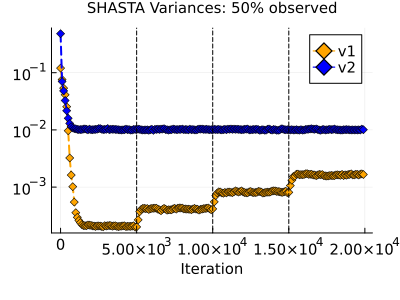

In [51]:
errs = [[[stat[1][ell] for stat in err_log_shasta]] for ell=1:L]

labels = ["v1","v2"]
colors = Dict("v1"=>:orange,"v2"=>:blue)
markers = Dict("v1"=>:diamond,"v2"=>:diamond)

missing_rate = Int(round((1-missing)*100))
interval = 100
alpha = 0.05
fontsize = 10
figsize = (400,300)


p1 = plottraces(errs,labels,colors,markers,interval,alpha,figsize,fontsize,
    "SHASTA Variances: $missing_rate% observed","Iteration",:topright,:log)
plot!(p1,size=figsize,bottom_margin=5mm,right_margin=5mm)

# [vline!([i],linestyle=:dash,color=:black,label="") for i=1:change:num_vectors]

for i=1:change:num_vectors
    if(i==1)
        continue
    end
    vline!(p1,[i],linestyle=:dash,color=:black,label="")
end
file = "/Users/kgilman/Desktop/mbp2022/streaming-hppca/Streaming-Heteroscedastic-PPCA/shasta_results/online_algs_dynamic_v1-v1_error-d_$d-n_$num_vectors-observedPercent_$missing_rate-v1_" * @sprintf("%.2E", v[1]) * "-v2_"* @sprintf("%.2E", v[2]) * ".pdf"
savefig(p1,file)
plot!(p1)

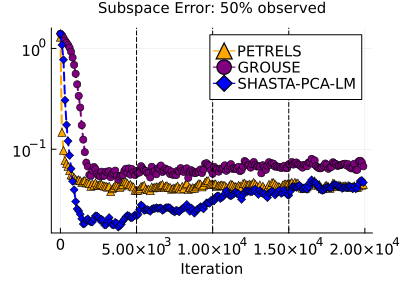

In [53]:
errs = [[[stat[2] for stat in err_log_petrels]],[[stat[2] for stat in err_log_grouse]],
    [[stat[2] for stat in err_log_shasta]]]

labels = ["PETRELS","GROUSE","SHASTA-PCA-LM"]
colors = Dict("PETRELS"=>:orange,"GROUSE"=>:purple,"SHASTA-PCA-LM"=>:blue)
markers = Dict("PETRELS"=>:utriangle,"GROUSE"=>:circle,"SHASTA-PCA-LM"=>:diamond)

missing_rate = Int(round((1-missing)*100))
interval = 100
alpha = 0.05
fontsize = 10
figsize = (400,300)


p1 = plottraces(errs,labels,colors,markers,interval,alpha,figsize,fontsize,
    "Subspace Error: $missing_rate% observed","Iteration",:topright,:log)

# [vline!([i],linestyle=:dash,color=:black,label="") for i=1:change:num_vectors]

for i=1:change:num_vectors
    if(i==1)
        continue
    end
    vline!(p1,[i],linestyle=:dash,color=:black,label="")
end
plot!(p1,size=figsize,bottom_margin=5mm,right_margin=5mm)
file = "/Users/kgilman/Desktop/mbp2022/streaming-hppca/Streaming-Heteroscedastic-PPCA/shasta_results/online_algs_dynamic_v1-U_error-d_$d-n_$num_vectors-observedPercent_$missing_rate-v1_" * @sprintf("%.2E", v[1]) * "-v2_"* @sprintf("%.2E", v[2]) * ".pdf"
savefig(p1,file)
plot!(p1)

In [32]:
v

2-element Vector{Float64}:
 0.0016
 0.01

##### Increasing v2

In [43]:
d, v, λ = 100, [1e-4,1e-2], [4,2,1]
k, L = length(λ), length(v)
θ = 0.998
# θ = 0.999
# θ = 1.
δ = 0.1

# w = 0.01
# wf = 0.01
# wv = 0.1

w = 0.01
cf = 0.01
cv = 0.1

# w1 = w
# w2 = w
grouse_step = 0.01
khat = 3

# num_vectors = 10000 #total number of vectors
num_vectors = 20000
p = [1/5 4/5] #probabilites to draw the two groups from
change = 5000
changeFIdx = 1:change:num_vectors

M0 = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),rand(L))

## Init models
M_petrels = deepcopy(M0)
M_shasta = deepcopy(M0)
M_grouse = deepcopy(M0)

## Memory terms

petrelsRₜ⁺ = [δ*Matrix(I(k)) for i=1:d]

R = [δ*Matrix(I(k)) for i=1:d]
s = [zeros(k) for i=1:d]
ρ = zeros(L)
θshasta = zeros(L)

## Init stat logs
err_log_onlineHeppcat = []
err_log_petrels = []
err_log_shasta = []
err_log_grouse = []

U = qr(rand(d,k)).Q[:,1:k]
F = U*sqrt(Diagonal(λ))

function Fmeasure(M,F)
#     Fhat = M.U * Diagonal(M.λ).^(0.5) * M.Vt
#     return norm(Fhat*Fhat' - F*F') / norm(F*F')
    Uf = svd(F).U[:,1:k]
    Uhat = M.U
    
    return norm(Uhat*Uhat' - Uf*Uf') / norm(Uf*Uf')
end

missing = 0.5
# err_fxn(M) = Fmeasure(M,F)
# err_fxn(M) = [abs(M.v[l] - v[l]) for l=1:L]
err_fxn(M) = deepcopy(M.v)
for t = 1:num_vectors
    
    ## Draw data vector
    if(t in changeFIdx)
        v[2] = 2*v[2]
#         err_fxn(M) = [abs(M.v[l] - v[l])/v[l] for l=1:L]
    end
    l = rand() > (p[2]) ? 1 : 2
    Ωₜ = rand(d) .> missing
    yₜ  = Ωₜ .* (F*randn(k) + sqrt(v[l])*randn(d))

    ## Run the models
    streamPETRELS!(M_petrels,yₜ,Ωₜ,petrelsRₜ⁺,θ)
#     streamSHASTA!(M,yₜ,Ωₜ,l,w,cf,cv,R,s,ρ,θ)
    streamSHASTA2!(M_shasta,yₜ,Ωₜ,l,w,cf,cv,R,s,ρ,θshasta)
    streamGROUSE!(M_grouse, yₜ, Ωₜ, grouse_step)
    
    ## Collect stats
    push!(err_log_petrels, [err_fxn(M_petrels), Fmeasure(M_petrels,F)])
    push!(err_log_shasta, [err_fxn(M_shasta), Fmeasure(M_shasta,F)])
    push!(err_log_grouse, [err_fxn(M_grouse), Fmeasure(M_grouse,F)])
    
end

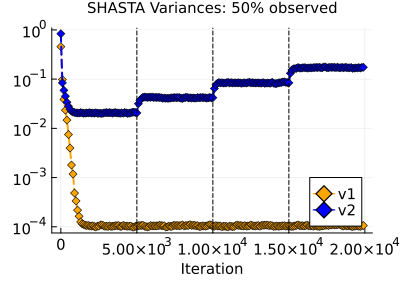

In [48]:
errs = [[[stat[1][ell] for stat in err_log_shasta]] for ell=1:L]

labels = ["v1","v2"]
colors = Dict("v1"=>:orange,"v2"=>:blue)
markers = Dict("v1"=>:diamond,"v2"=>:diamond)

missing_rate = Int(round((1-missing)*100))
interval = 100
alpha = 0.05
fontsize = 10
figsize = (400,300)


p1 = plottraces(errs,labels,colors,markers,interval,alpha,figsize,fontsize,
    "SHASTA Variances: $missing_rate% observed","Iteration",:bottomright,:log)
plot!(p1,size=figsize,bottom_margin=5mm,right_margin=5mm)

for i=1:change:num_vectors
    if(i==1)
        continue
    end
    vline!(p1,[i],linestyle=:dash,color=:black,label="")
end

file = "/Users/kgilman/Desktop/mbp2022/streaming-hppca/Streaming-Heteroscedastic-PPCA/shasta_results/online_algs_dynamic_v2-v_error-d_$d-n_$num_vectors-observedPercent_$missing_rate-v1_" * @sprintf("%.2E", v[1]) * "-v2_"* @sprintf("%.2E", v[2]) * ".pdf"
savefig(p1,file)
plot!(p1)

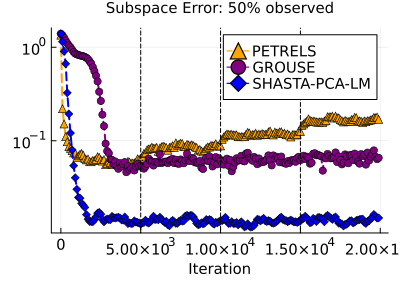

In [47]:
errs = [[[stat[2] for stat in err_log_petrels]],[[stat[2] for stat in err_log_grouse]],
    [[stat[2] for stat in err_log_shasta]]]

labels = ["PETRELS","GROUSE","SHASTA-PCA-LM"]
colors = Dict("PETRELS"=>:orange,"GROUSE"=>:purple,"SHASTA-PCA-LM"=>:blue)
markers = Dict("PETRELS"=>:utriangle,"GROUSE"=>:circle,"SHASTA-PCA-LM"=>:diamond)

missing_rate = Int(round((1-missing)*100))
interval = 100
alpha = 0.05
fontsize = 10
figsize = (400,300)


p1 = plottraces(errs,labels,colors,markers,interval,alpha,figsize,fontsize,
    "Subspace Error: $missing_rate% observed","Iteration",:topright,:log)
plot!(p1,size=figsize,bottom_margin=5mm)


for i=1:change:num_vectors
    if(i==1)
        continue
    end
    vline!(p1,[i],linestyle=:dash,color=:black,label="")
end
file = "/Users/kgilman/Desktop/mbp2022/streaming-hppca/Streaming-Heteroscedastic-PPCA/shasta_results/online_algs_dynamic_v2-U_error-d_$d-n_$num_vectors-observedPercent_$missing_rate-v1_" * @sprintf("%.2E", v[1]) * "-v2_"* @sprintf("%.2E", v[2]) * ".pdf"
savefig(p1,file)
plot!(p1)